In [1]:
import os
import subprocess
from pathlib import Path

"""
Dynamically find the project root (where .git exists) and set it as the current working directory.
"""
project_root = Path(subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip())
os.chdir(project_root)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu

In [ ]:
#rankings data with beer_location and user_location added as extra columns
RB_merged = pd.read_csv('data/minimizedData/RB_ratings_small_plus.csv')

In [30]:
print(RB_merged.shape)
RB_merged_clean = RB_merged.dropna(subset=['beer_location','user_location','rating'])
print(RB_merged_clean.shape)
#we are only interested in focusing on the ratings that originate from US users AND are for US beers
US_ratings = RB_merged_clean[RB_merged_clean['user_location'].str.startswith('United States,')]
US_ratings = US_ratings[US_ratings['beer_location'].str.startswith('United States,')]
print(US_ratings.shape)
US_ratings.tail(2)

(7123806, 15)
(6920087, 15)
(2396446, 15)


,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,user_location,avg,beer_location
5595392,Tracks Light Rail Lager,34920.0,Tracks Brewing Company &#40;USA&#41;,4800.0,Pale Lager,58936.0,3.0,5.0,3.0,6.0,13.0,3.0,"United States, Oregon",2.84,"United States, Utah"
5595393,Tracks Skull Valley Stout,34921.0,Tracks Brewing Company &#40;USA&#41;,4800.0,Stout,58936.0,4.0,6.0,4.0,6.0,13.0,3.3,"United States, Oregon",2.96,"United States, Utah"


In [31]:
#removing the United States part from the location for both beer and user for clarity
US_ratings['user_state'] = US_ratings['user_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings['beer_state'] = US_ratings['beer_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings = US_ratings.drop(['user_location','beer_location'], axis=1)
print(US_ratings.shape)
US_ratings = US_ratings[(US_ratings['user_state'] != 'United States') & (US_ratings['beer_state'] != 'United States')]
US_ratings.shape

(2396446, 15)


(2396446, 15)

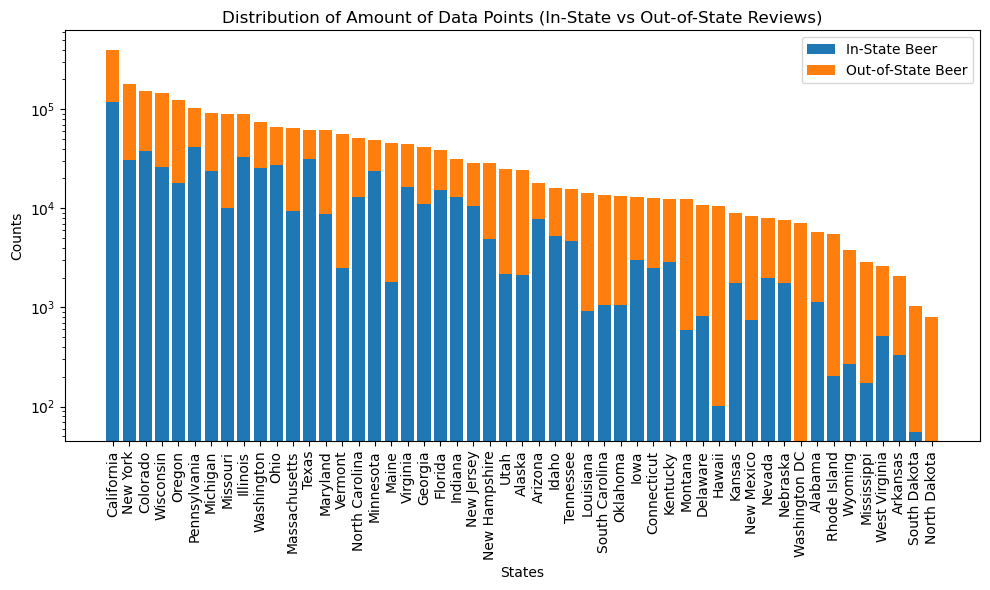

Hawaii in-state beer reviews: 102


In [32]:
US_ratings['beer_origin'] = np.where(
    US_ratings['beer_state'] == US_ratings['user_state'],
    'In-State Beer', 
    'Out-of-State Beer'
)

counts = US_ratings.groupby('beer_state')['avg'].count().sort_values(ascending=False)

in_out_counts = US_ratings.groupby(['beer_state', 'beer_origin'])['avg'].count().unstack(fill_value=0)

in_out_counts = in_out_counts.loc[counts.index]

plt.figure(figsize=(10, 6))

states = in_out_counts.index
ind = np.arange(len(states))
width = 0.8  # Bar width

plt.bar(ind, in_out_counts['In-State Beer'], width, label='In-State Beer')
plt.bar(ind, in_out_counts['Out-of-State Beer'], width,
        bottom=in_out_counts['In-State Beer'], label='Out-of-State Beer')

plt.title("Distribution of Amount of Data Points (In-State vs Out-of-State Reviews)")
plt.xlabel("States")
plt.xticks(ind, states, rotation=90)
plt.yscale('log')  # Use a logarithmic scale on the y-axis
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()
plt.show()

print('Hawaii in-state beer reviews:', in_out_counts.loc['Hawaii', 'In-State Beer'])

We have to remove:
- North Dakota
- South Dakota 
- Washington DC
- Hawaii

In [33]:
state_ratings = US_ratings.groupby(['user_state', 'beer_state'])['avg'].mean().reset_index()
state_ratings.head(2)

,user_state,beer_state,avg
0,Alabama,Alabama,3.156822
1,Alabama,Alaska,3.510671


In [34]:
state_ratings_matrix = state_ratings.pivot_table(index='user_state', columns='beer_state', values='avg', fill_value=0)
state_ratings_matrix.head(2)

beer_state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,Washington DC,West Virginia,Wisconsin,Wyoming
user_state,,,,,,,,,,,,,,,,,,,,,
Alabama,3.156822,3.510671,3.233623,2.901429,3.587915,3.245265,3.523333,3.289362,3.124645,3.395977,...,3.119425,3.235878,3.438023,3.221684,3.376535,3.234142,3.351034,2.954,2.848292,3.242800
Alaska,3.323333,3.271551,3.244000,3.030000,3.646224,3.351927,3.416667,3.428462,3.186143,3.475263,...,3.125556,3.330000,3.228353,3.613077,3.406667,3.350969,3.365000,3.035,2.855680,3.290833


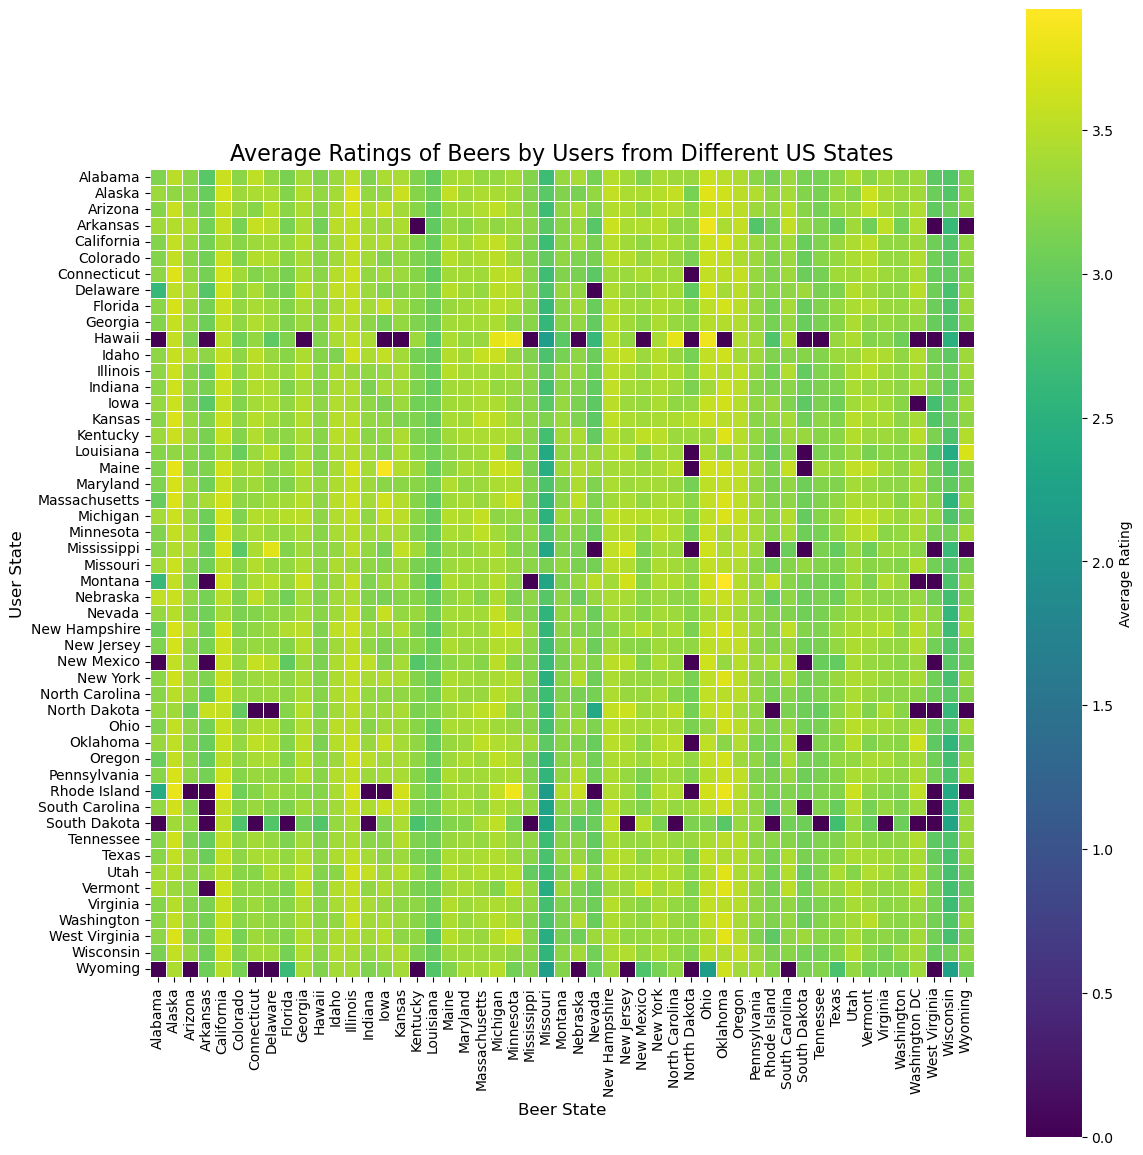

In [35]:
plt.figure(figsize=(12, 12))

sns.heatmap(state_ratings_matrix, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5, cbar_kws={'label': 'Average Rating'}, square=True)

plt.title('Average Ratings of Beers by Users from Different US States', fontsize=16)
plt.xlabel('Beer State', fontsize=12)
plt.ylabel('User State', fontsize=12)
plt.tight_layout()

plt.show()

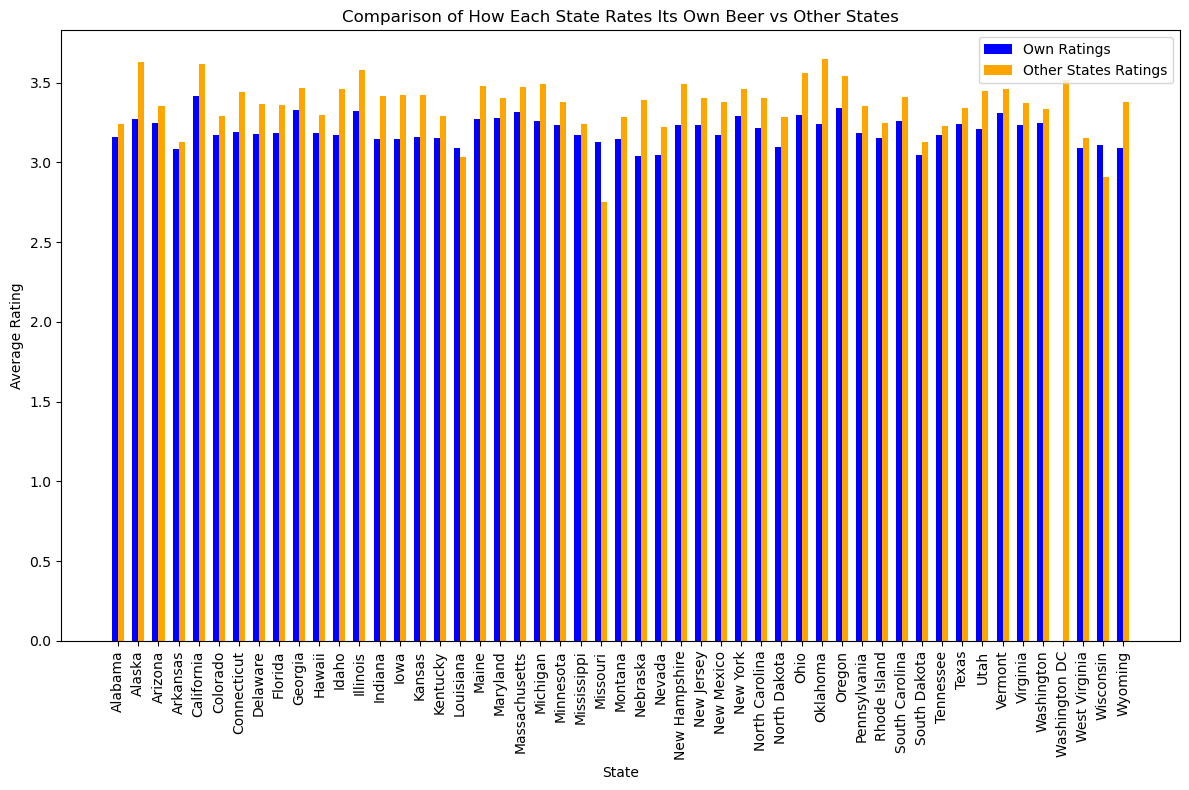

In [36]:
#average ratings for each state when rating its own beer
own_beer_ratings = US_ratings[US_ratings['user_state'] == US_ratings['beer_state']].groupby('beer_state')['avg'].mean()

#total number of ratings per beer_state
total_ratings_per_state = US_ratings.groupby('beer_state').size()

#weighted average rating for each beer by other states
other_state_ratings = US_ratings[US_ratings['user_state'] != US_ratings['beer_state']]
other_state_avg_ratings = other_state_ratings.groupby('beer_state').apply(
    lambda group: np.average(group['rating'], weights=group['user_state'].map(total_ratings_per_state))
)

ratings_comparison = pd.DataFrame({
    'own_beer_avg': own_beer_ratings,
    'other_states_avg': other_state_avg_ratings
})

ratings_comparison['other_states_avg'] = ratings_comparison['other_states_avg'].fillna(0)
plt.figure(figsize=(12, 8))

bar_width = 0.3
index = np.arange(len(ratings_comparison)) 

#allows us to place the bars next to each other
plt.bar(index - bar_width / 2, ratings_comparison['own_beer_avg'], bar_width, label='Own Ratings', color='blue')
plt.bar(index + bar_width / 2, ratings_comparison['other_states_avg'], bar_width, label='Other States Ratings', color='orange')

plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of How Each State Rates Its Own Beer vs Other States')
plt.xticks(index, ratings_comparison.index, rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

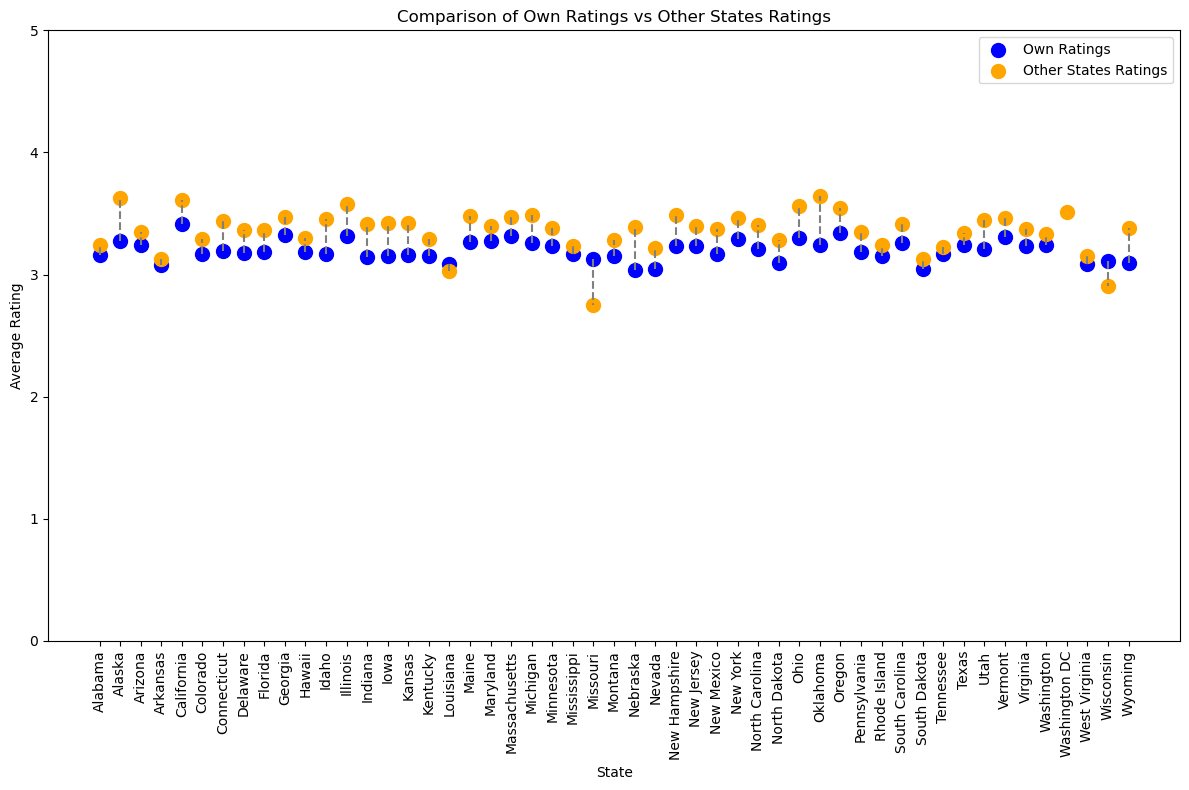

In [37]:
plt.figure(figsize=(12, 8))

#dots for better visibility
plt.scatter(ratings_comparison.index, ratings_comparison['own_beer_avg'], label='Own Ratings', color='blue', s=100, zorder=2)
plt.scatter(ratings_comparison.index, ratings_comparison['other_states_avg'], label='Other States Ratings', color='orange', s=100, zorder=2)

#lines connecting the dots for visibility
for i in range(len(ratings_comparison)):
    plt.plot([ratings_comparison.index[i], ratings_comparison.index[i]], 
             [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]], 
             color='gray', linestyle='--')

plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of Own Ratings vs Other States Ratings')
plt.xticks(rotation=90)
plt.ylim(0,5)
plt.legend()
plt.tight_layout()

plt.show()

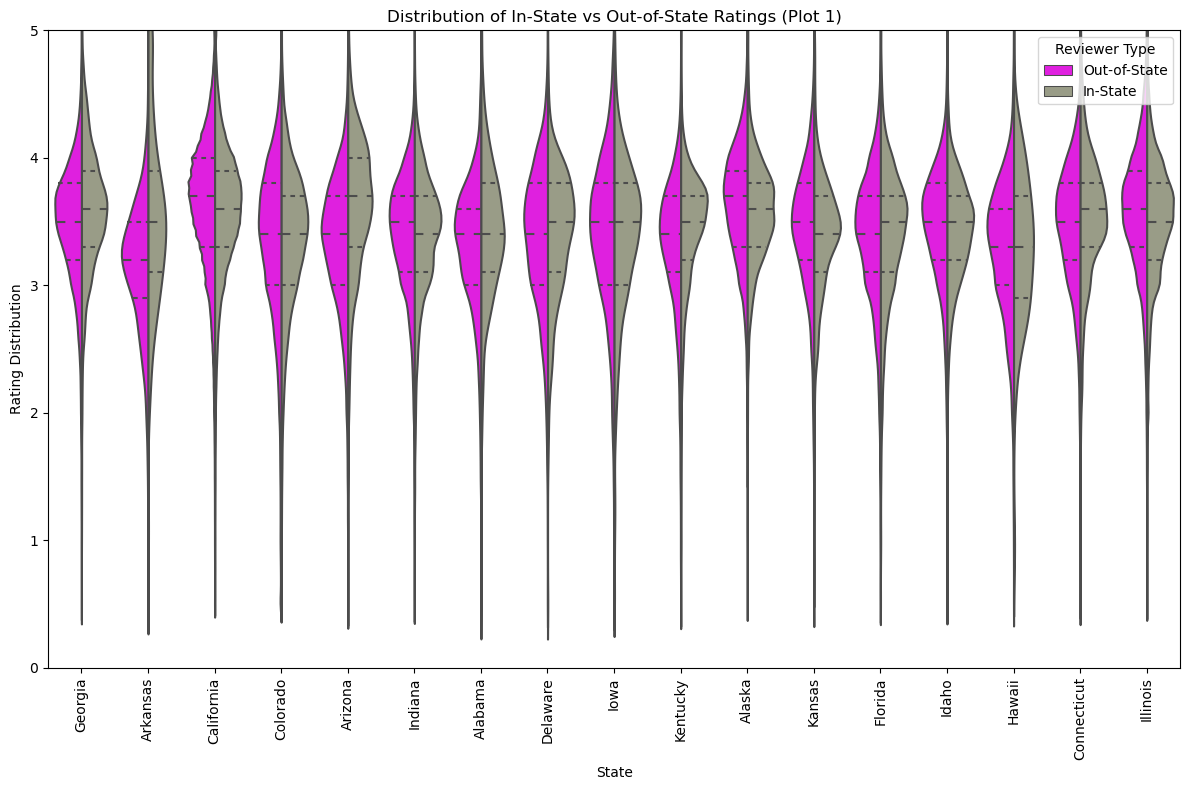

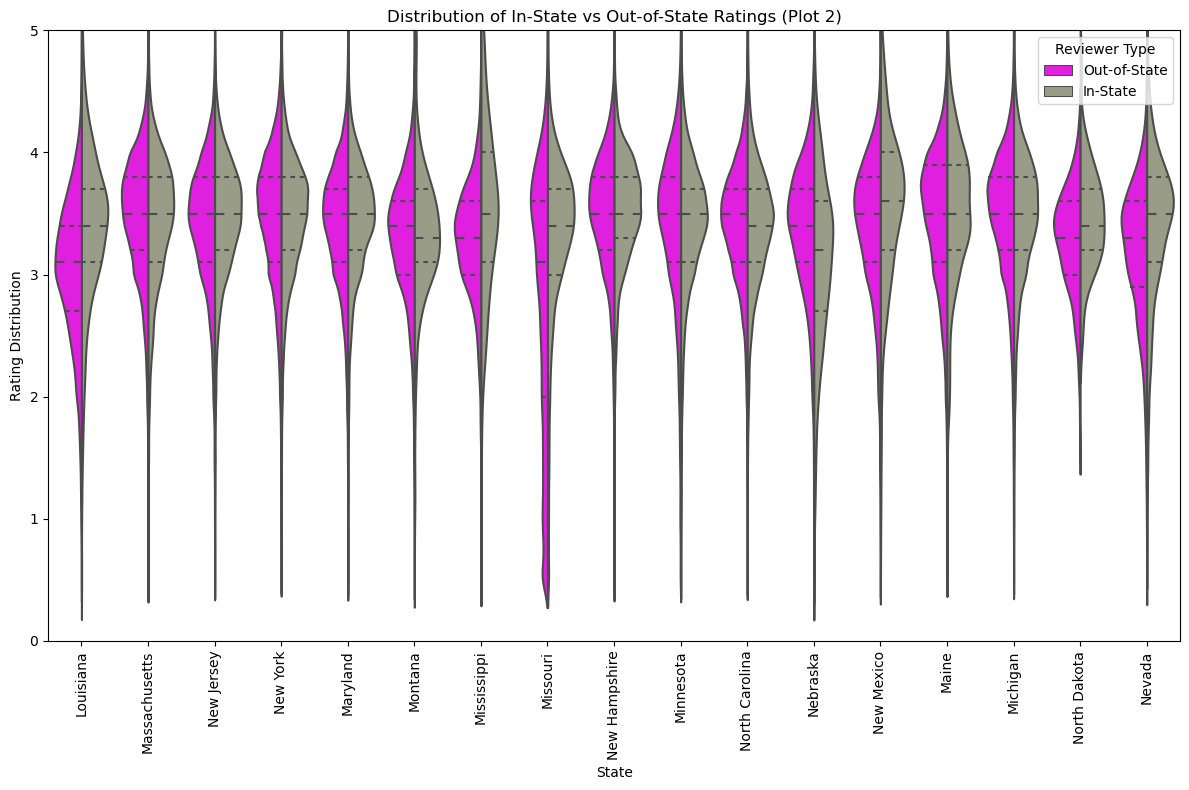

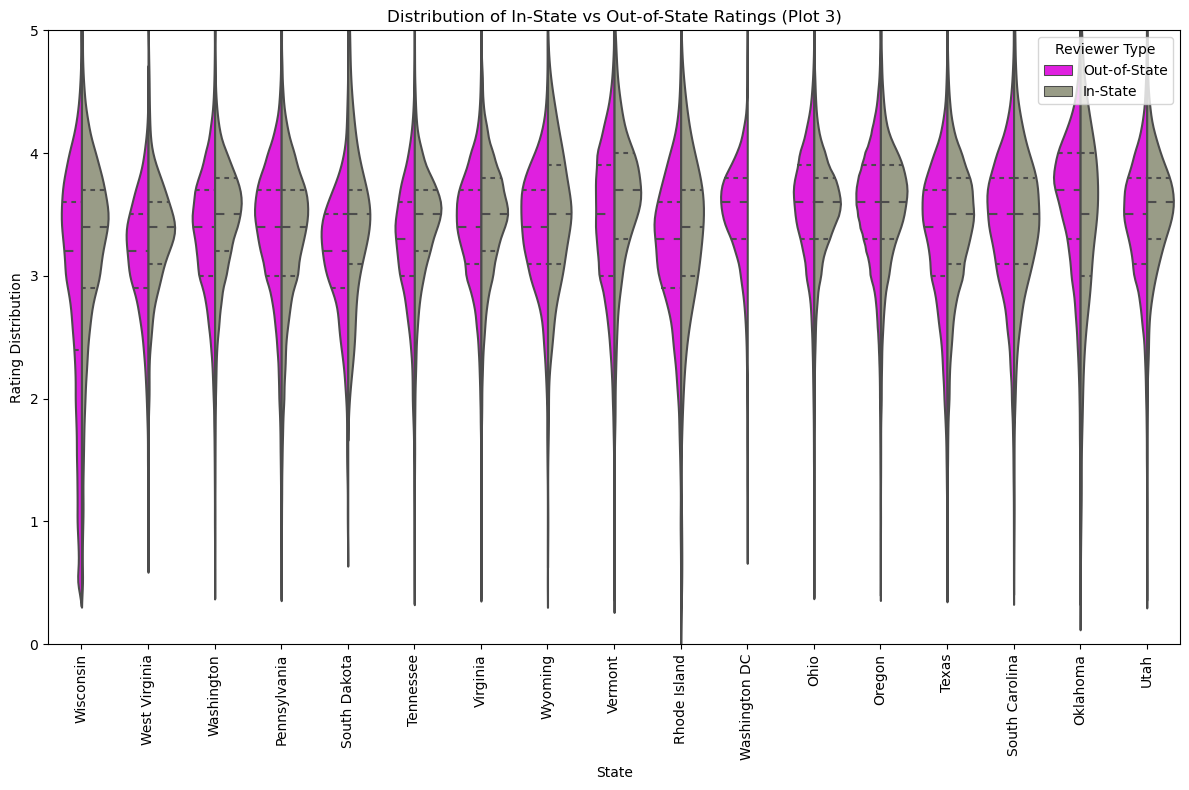

In [38]:
import math

US_ratings['state_IN_VS_OUT'] = np.where(
    US_ratings['user_state'] == US_ratings['beer_state'], 
    'In-State', 
    'Out-of-State'
)

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()  

num_figures = 3  
num_states = len(unique_states)
states_per_figure = math.ceil(num_states / num_figures)

custom_palette = ['magenta', '#9c9f84'] 

for i in range(num_figures):
    start_idx = i * states_per_figure
    end_idx = min((i + 1) * states_per_figure, num_states)
    subset_states = unique_states[start_idx:end_idx]
    
    subset_data = US_ratings[US_ratings['beer_state'].isin(subset_states)]
    
    plt.figure(figsize=(12, 8))
    sns.violinplot(
        x='beer_state', 
        y='rating', 
        hue='state_IN_VS_OUT', 
        data=subset_data, 
        palette=custom_palette, 
        split=True, 
        inner='quartile'
    )

    plt.xlabel('State')
    plt.ylabel('Rating Distribution')
    plt.title(f'Distribution of In-State vs Out-of-State Ratings (Plot {i+1})')
    plt.xticks(rotation=90)
    plt.ylim(0, 5)
    plt.legend(title='Reviewer Type')
    plt.tight_layout()
    plt.show()


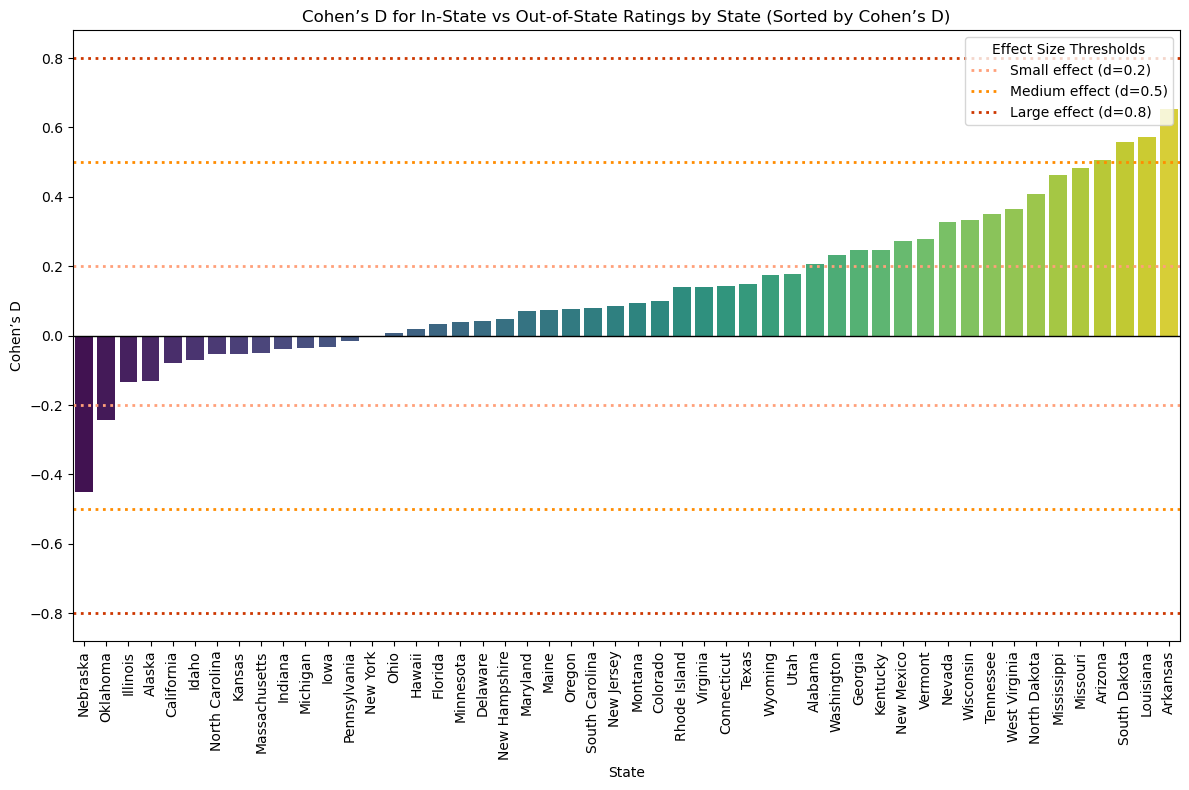

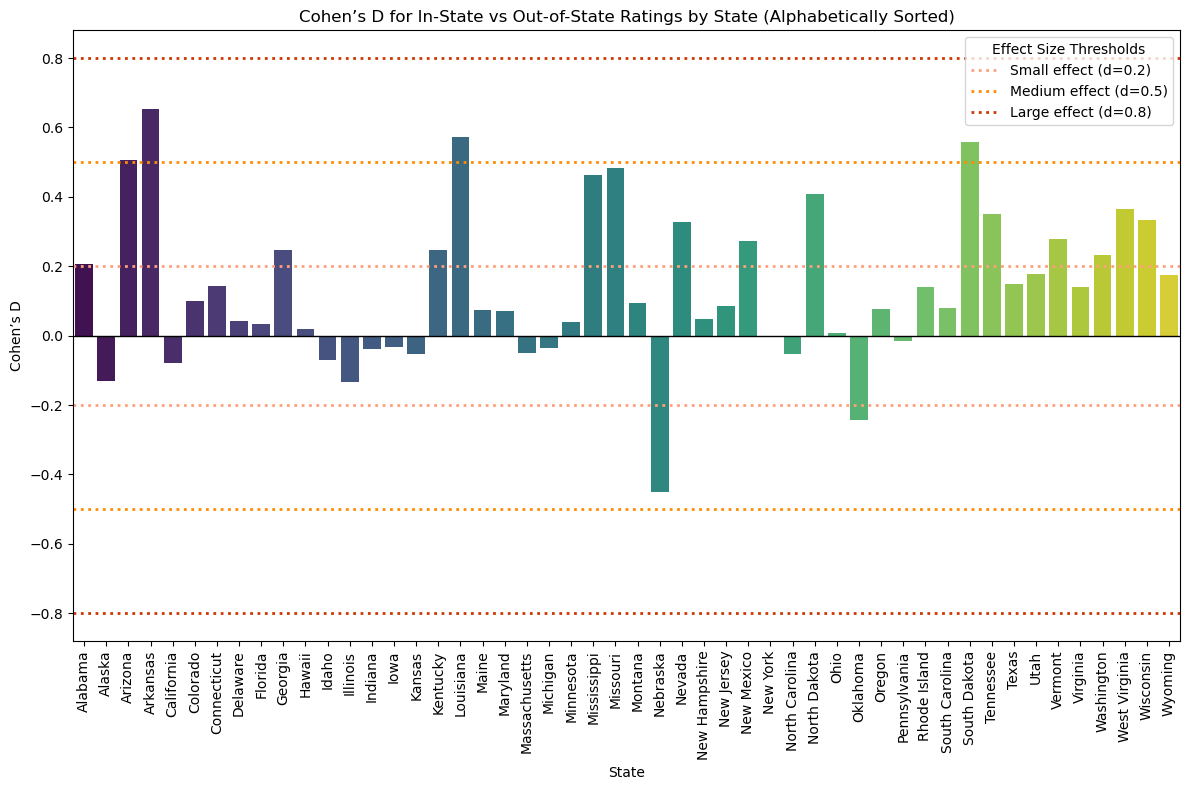

In [46]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()

cohen_results = {}

for state in unique_states:
    subset = US_ratings[US_ratings['beer_state'] == state]
    in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['rating']
    out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['rating']
    
    if len(in_state_ratings) == 0 or len(out_of_state_ratings) == 0:
        cohen_results[state] = np.nan
        continue
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    cohen_results[state] = d_value

cohen_df = pd.DataFrame.from_dict(cohen_results, orient='index', columns=['Cohen_d'])
cohen_df.sort_values(by='Cohen_d', inplace=True)  # Sort by Cohen's D value

cohen_df_no_nan = cohen_df.dropna()

# Plot 1: States sorted by Cohen's D value
plt.figure(figsize=(12, 8))
sns.barplot(
    x=cohen_df_no_nan.index, 
    y='Cohen_d', 
    data=cohen_df_no_nan, 
    palette='viridis'
)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for In-State vs Out-of-State Ratings by State (Sorted by Cohen’s D)')
plt.xticks(rotation=90)
plt.legend(title='Effect Size Thresholds', loc='upper right')
plt.tight_layout()
plt.show()

# Plot 2: States sorted alphabetically
cohen_alphabetical = cohen_df_no_nan.copy()
cohen_alphabetical.sort_index(inplace=True)  # Sort by state name (index)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=cohen_alphabetical.index, 
    y='Cohen_d', 
    data=cohen_alphabetical, 
    palette='viridis'
)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for In-State vs Out-of-State Ratings by State (Alphabetically Sorted)')
plt.xticks(rotation=90)
plt.legend(title='Effect Size Thresholds', loc='upper right')
plt.tight_layout()
plt.show()


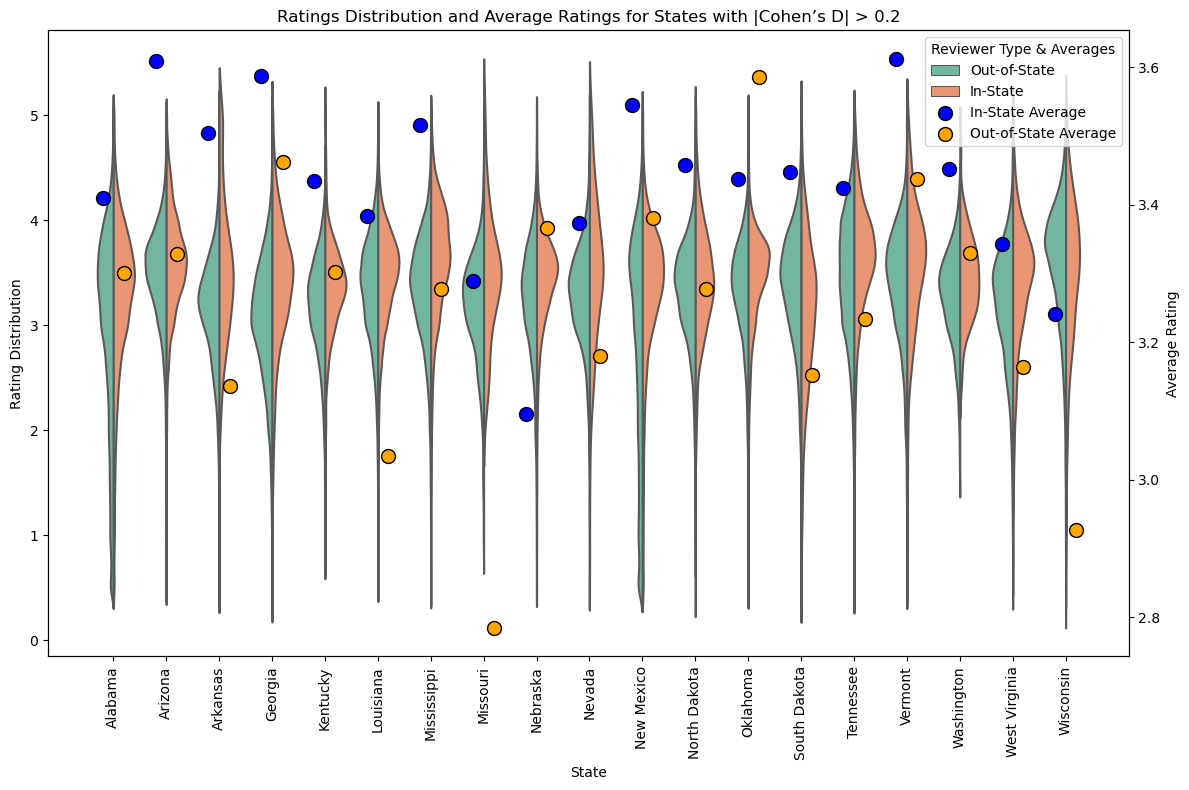

In [40]:
significant_states = cohen_df_no_nan[
    (cohen_df_no_nan['Cohen_d'] > 0.2) | (cohen_df_no_nan['Cohen_d'] < -0.2)
].index
significant_states = sorted(significant_states)

filtered_ratings = US_ratings[US_ratings['beer_state'].isin(significant_states)]

average_ratings = filtered_ratings.groupby(['beer_state', 'state_IN_VS_OUT'])['rating'].mean().reset_index()

plt.figure(figsize=(12, 8))

ax1 = sns.violinplot(
    x='beer_state', 
    y='rating', 
    hue='state_IN_VS_OUT', 
    data=filtered_ratings, 
    split=True, 
    inner=None, 
    palette='Set2'
)

ax1.legend_.remove()

ax1.set_xlabel('State')
ax1.set_ylabel('Rating Distribution')
ax1.set_title('Ratings Distribution and Average Ratings for States with |Cohen’s D| > 0.2')

ax2 = ax1.twinx()

colors = {'In-State': 'blue', 'Out-of-State': 'orange'}

labels_added = set()  

for i, state in enumerate(significant_states):
    state_avg_ratings = average_ratings[average_ratings['beer_state'] == state]
    
    for relation, color in colors.items():
        avg_value = state_avg_ratings[state_avg_ratings['state_IN_VS_OUT'] == relation]['rating']
        if not avg_value.empty:
            x_pos = i  # Position at the state's index
            offset = -0.2 if relation == 'In-State' else 0.2
            label = f'{relation} Average' if f'{relation} Average' not in labels_added else None
            
            ax2.scatter(x_pos + offset, avg_value, 
                        color=color, 
                        edgecolor='black', 
                        s=100, 
                        zorder=3, 
                        label=label)
            if label is not None:
                labels_added.add(label)

ax2.set_ylabel('Average Rating')

ax1.set_xticks(range(len(significant_states)))  
ax1.set_xticklabels(significant_states, rotation=90)  

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines_combined, labels_combined = [], []
for l, la in zip(lines_1 + lines_2, labels_1 + labels_2):
    if la not in labels_combined:
        lines_combined.append(l)
        labels_combined.append(la)

ax1.legend(lines_combined, labels_combined, title='Reviewer Type & Averages', loc='upper right')

plt.tight_layout()
plt.show()

             state  average_in_state  average_out_of_state  difference  \
0     Rhode Island          3.310837              3.492003   -0.181166   
1         Nebraska          3.096487              3.256351   -0.159864   
2        Wisconsin          3.241599              3.400883   -0.159284   
3           Hawaii          3.285294              3.366539   -0.081245   
4         Missouri          3.289415              3.368746   -0.079332   
5         Delaware          3.382007              3.431791   -0.049784   
6           Nevada          3.373814              3.414842   -0.041027   
7         Colorado          3.354854              3.386115   -0.031261   
8            Idaho          3.416781              3.440093   -0.023312   
9     Pennsylvania          3.331401              3.351768   -0.020367   
10  North Carolina          3.381338              3.379529    0.001809   
11            Iowa          3.368251              3.363816    0.004435   
12          Kansas          3.394906  

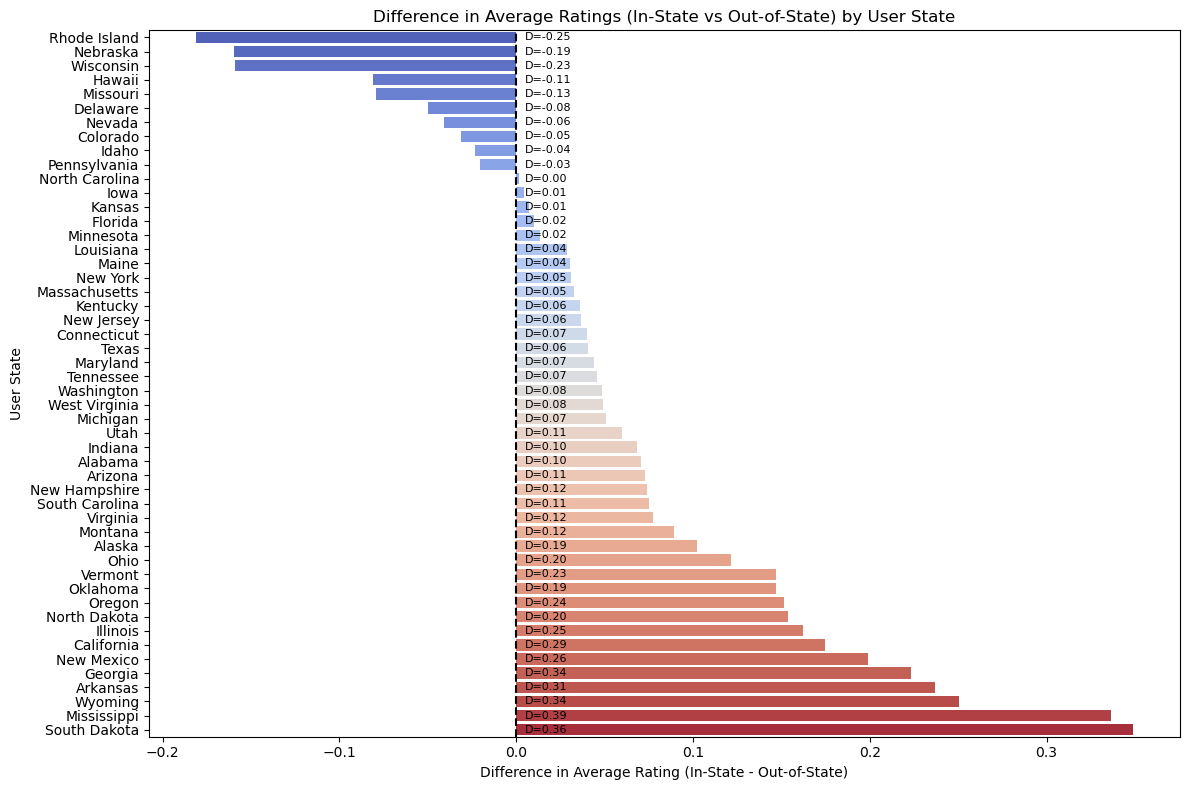

           state  average_in_state  average_out_of_state  difference   cohen_d
0   Rhode Island          3.310837              3.492003   -0.181166 -0.249136
1      Wisconsin          3.241599              3.400883   -0.159284 -0.234181
2           Ohio          3.539358              3.417873    0.121485  0.202501
3        Vermont          3.612616              3.465714    0.146902  0.234302
4         Oregon          3.571720              3.419976    0.151744  0.238168
5   North Dakota          3.457778              3.303994    0.153784  0.200955
6       Illinois          3.496013              3.333549    0.162463  0.245409
7     California          3.571112              3.396550    0.174562  0.285941
8     New Mexico          3.545384              3.346602    0.198782  0.260561
9        Georgia          3.587031              3.363505    0.223526  0.341078
10      Arkansas          3.504985              3.268298    0.236687  0.310319
11       Wyoming          3.474074              3.22

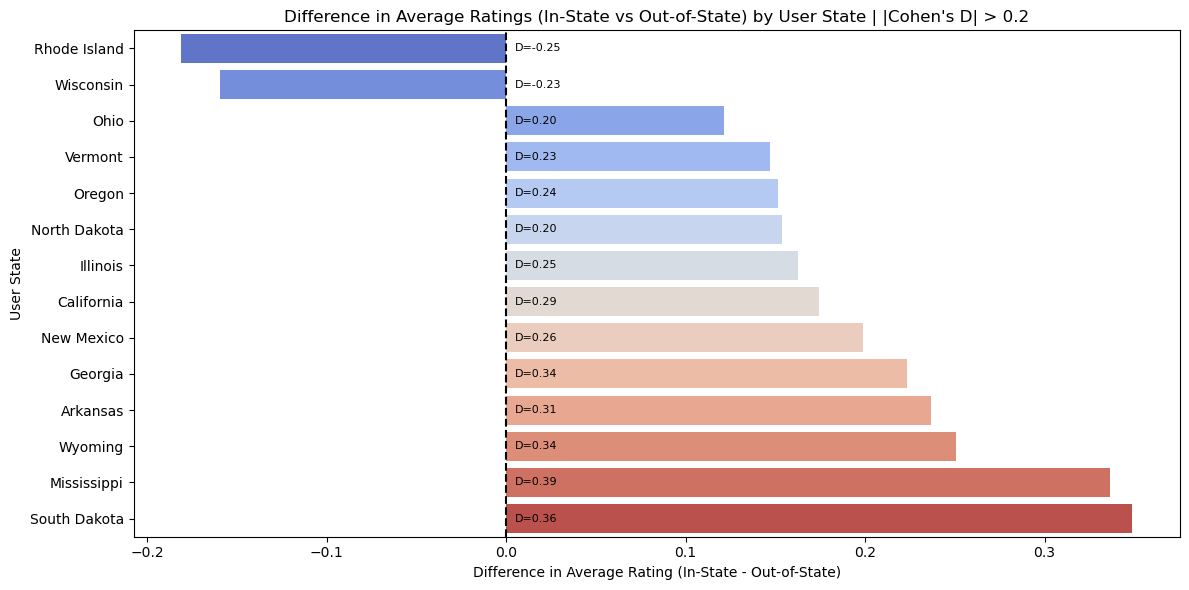

In [41]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)  # Using sample standard deviation
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['user_state'].unique()

results = []

for state in unique_states:
    state_users = US_ratings[US_ratings['user_state'] == state].copy()
    
    if state_users.empty:
        continue
    
    state_users['beer_origin'] = np.where(
        state_users['beer_state'] == state, 
        'In-State Beer', 
        'Out-of-State Beer'
    )
    
    in_state_ratings = state_users[state_users['beer_origin'] == 'In-State Beer']['rating']
    out_of_state_ratings = state_users[state_users['beer_origin'] == 'Out-of-State Beer']['rating']
    
    if in_state_ratings.empty or out_of_state_ratings.empty:
        continue
    
    average_in_state = in_state_ratings.mean()
    average_out_of_state = out_of_state_ratings.mean()
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    
    rating_diff = average_in_state - average_out_of_state
    
    results.append({
        'state': state,
        'average_in_state': average_in_state,
        'average_out_of_state': average_out_of_state,
        'difference': rating_diff,
        'cohen_d': d_value
    })

state_results = pd.DataFrame(results)
state_results.sort_values(by='difference', inplace=True)  # Sort by difference
state_results.reset_index(drop=True, inplace=True)

print(state_results)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')
plt.title("Difference in Average Ratings (In-State vs Out-of-State) by User State")
plt.ylabel("User State")
plt.xlabel("Difference in Average Rating (In-State - Out-of-State)")
plt.axvline(0, color='black', linestyle='--')

for i, row in state_results.iterrows():
    d_val = f"D={row['cohen_d']:.2f}" if not pd.isna(row['cohen_d']) else "D=NaN"
    text_x = 0.005  
    ax.text(text_x, i, d_val, 
            color='black', ha='left', va='center', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

filtered_results = state_results[abs(state_results['cohen_d']) > 0.2].copy()
filtered_results.sort_values(by='difference', inplace=True)
filtered_results.reset_index(drop=True, inplace=True)

print(filtered_results)

plt.figure(figsize=(12, 6))
ax2 = sns.barplot(data=filtered_results, y='state', x='difference', palette='coolwarm', orient='h')
plt.title("Difference in Average Ratings (In-State vs Out-of-State) by User State | |Cohen's D| > 0.2")
plt.xlabel("Difference in Average Rating (In-State - Out-of-State)")
plt.ylabel("User State")
plt.axvline(0, color='black', linestyle='--')

for i, row in filtered_results.iterrows():
    d_val = f"D={row['cohen_d']:.2f}" if not pd.isna(row['cohen_d']) else "D=NaN"
    text_x = 0.005  
    ax2.text(text_x, i, d_val, 
             color='black', ha='left', va='center', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

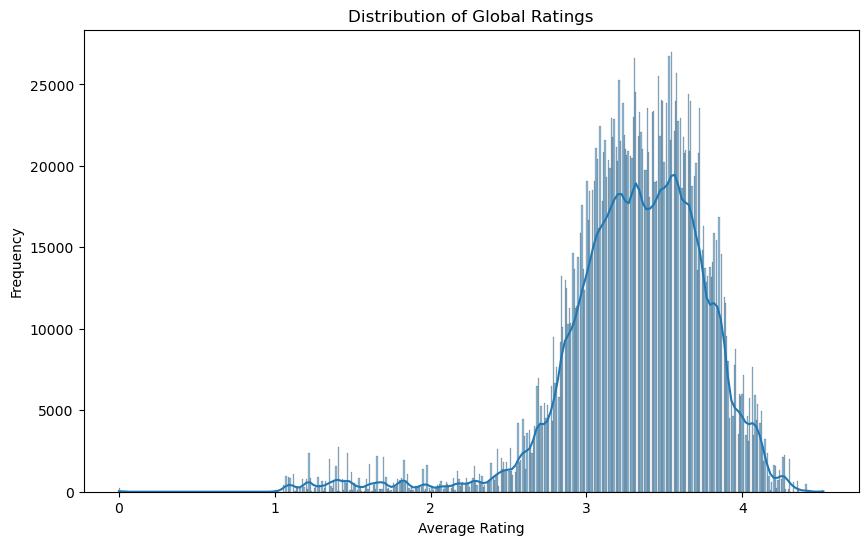

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(US_ratings['avg'], kde=True)
plt.title("Distribution of Global Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

In [44]:
#Test allows us to statistically verify if the data is normally distributed
ks_test = stats.kstest(US_ratings['avg'], 'norm', args=(US_ratings['avg'].mean(), US_ratings['avg'].std()))
print("Kolmogorov-Smirnov Test:")
print(f"Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")

Kolmogorov-Smirnov Test:
Statistic=nan, p-value=nan


             state  state_avg  other_states_avg        p_value  \
19        Missouri   3.289415          2.784561   0.000000e+00   
46        Arkansas   3.504985          3.137167   7.516954e-20   
47       Louisiana   3.383477          3.034922   2.411232e-66   
2        Wisconsin   3.241599          2.926556   0.000000e+00   
39    South Dakota   3.447273          3.152929   3.135514e-04   
17         Arizona   3.609929          3.329311  9.573752e-279   
22     Mississippi   3.516571          3.277811   1.801651e-07   
41          Nevada   3.373814          3.180586   3.251715e-47   
33       Tennessee   3.424015          3.234277   7.201564e-98   
37    North Dakota   3.457778          3.278342   2.004136e-02   
15   West Virginia   3.343378          3.163952   6.325799e-14   
34         Vermont   3.612616          3.437117   8.883989e-47   
25      New Mexico   3.545384          3.381254   7.473303e-14   
21        Kentucky   3.435502          3.302694   1.642129e-38   
30        

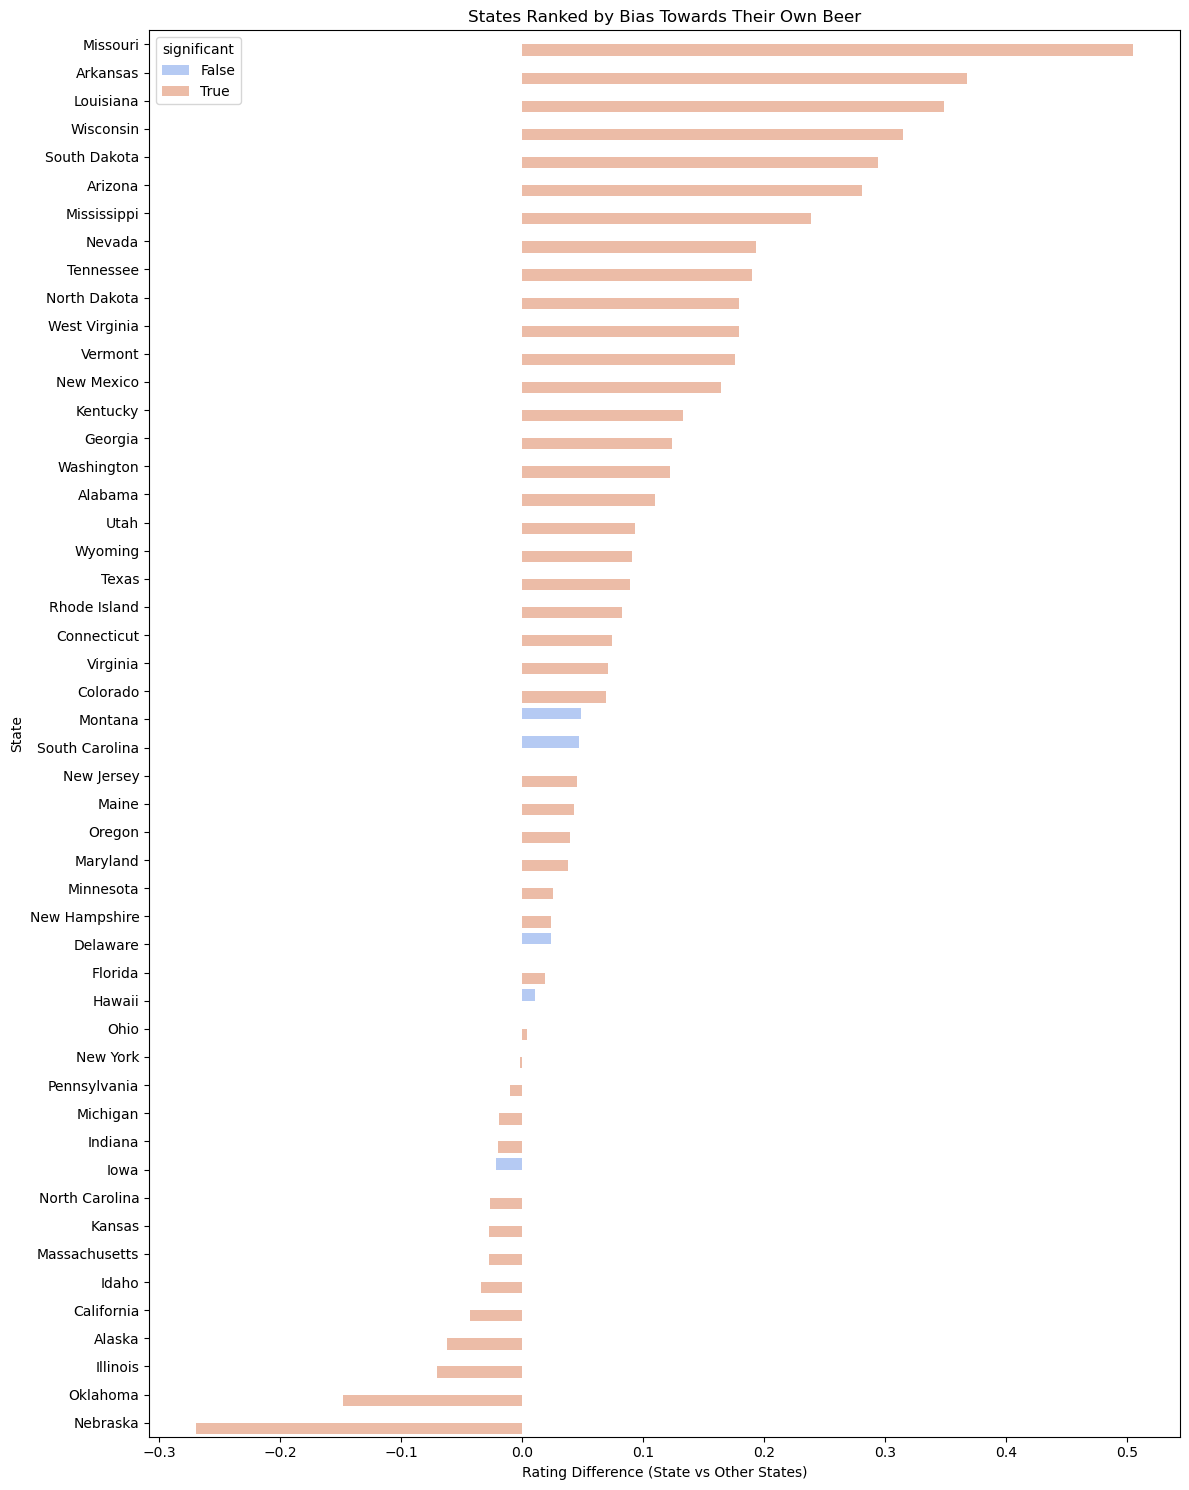

In [45]:
#calculate Mann-Whitney U and average ratings for each state
def calculate_bias(state, US_ratings):

    state_ratings = US_ratings[(US_ratings['user_state'] == state) & (US_ratings['beer_state'] == state)]['rating']
    other_states_ratings = US_ratings[(US_ratings['user_state'] != state) & (US_ratings['beer_state'] == state)]['rating']
    
    state_avg = state_ratings.mean()
    other_states_avg = other_states_ratings.mean()
    
    stat, p_value = mannwhitneyu(state_ratings, other_states_ratings, alternative='two-sided')
    
    return state_avg, other_states_avg, p_value


states = US_ratings['user_state'].unique()

bias_results = []

for state in states:
    state_avg, other_states_avg, p_value = calculate_bias(state, US_ratings)
    bias_results.append({
        'state': state,
        'state_avg': state_avg,
        'other_states_avg': other_states_avg,
        'p_value': p_value,
        'rating_difference': state_avg - other_states_avg
    })


bias_df = pd.DataFrame(bias_results)

bias_df['significant'] = bias_df['p_value'] < 0.05


bias_df = bias_df.sort_values(by=['rating_difference', 'significant'], ascending=False)
print(bias_df)

num_states = len(bias_df)
plt.figure(figsize=(12, max(8, num_states * 0.3)))
sns.barplot(x='rating_difference', y='state', data=bias_df, palette='coolwarm', hue='significant')

plt.xlabel('Rating Difference (State vs Other States)')
plt.ylabel('State')
plt.title('States Ranked by Bias Towards Their Own Beer')
plt.tight_layout()

plt.show()